# Content analysis

- What are the parliamentary questions about?
- What are the most common recurring topcis?
- Which documents talk about a specific document

# Reading in data

In [1]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd

In [3]:
path = './data/parliamentary-questions_2023_sample.csv'
data = pd.read_csv(path, index_col=1)

In [4]:
data

,Unnamed: 0,document_title,document_type,document_date,question_text,answer_text
document_identifier,,,,,,
E-9-2023-000080,0,Suspension of the payment of funds to Morocco ...,Written question,2023-01-11,PE741.317v01-00Question for written answer E-0...,EN\nE-000080/2023\nAnswer given by Mr Várhelyi...
E-9-2023-000114,1,Shortage of medicines in Greece and the EU,Written question,2023-01-16,PE741.347v01-00Question for written answer E-0...,EN\nE-000114/2023\nAnswer given by Ms Kyriakid...
E-9-2023-000012,2,Declaration of the state of emergency in Peru ...,Written question,2023-01-05,PE741.232v01-00Question for written answer E-0...,EN\nE-000012/2023\nAnswer given by High Repres...
E-9-2023-000074,3,Shortage of medicines,Written question,2023-01-11,PE741.310v01-00Question for written answer E-0...,(English version)\nQuestion for written answer...
E-9-2023-000034,4,Emergency interventions to address high energy...,Written question,2023-01-09,PE741.254v01-00Question for written answer E-0...,EN\nE-000034/2023\nAnswer given by Ms Simson\n...
...,...,...,...,...,...,...
P-9-2023-001267,1498,EU response to the Egyptian President’s order ...,EP priority written question,2023-04-19,PE747.332v01-00Priority question for written a...,NaN
P-9-2023-001146,1499,Most efficient installations in the sectors co...,EP priority written question,2023-04-05,PE747.143v02-00Priority question for written a...,NaN
P-9-2023-001529,1500,Workers’ rights in Myanmar under the MADE in M...,EP priority written question,2023-05-10,PE749.414v01-00Priority question for written a...,NaN


# Preparation

In [5]:
# Join answers and questions texts together to get all context
data[['question_text', 'answer_text']] = data[['question_text', 'answer_text']].fillna(value='')
data['text'] = data['question_text'].str.cat(data['answer_text'], sep=' -- ')

In [6]:
data.text

document_identifier
E-9-2023-000080    PE741.317v01-00Question for written answer E-0...
E-9-2023-000114    PE741.347v01-00Question for written answer E-0...
E-9-2023-000012    PE741.232v01-00Question for written answer E-0...
E-9-2023-000074    PE741.310v01-00Question for written answer E-0...
E-9-2023-000034    PE741.254v01-00Question for written answer E-0...
                                         ...                        
P-9-2023-001267    PE747.332v01-00Priority question for written a...
P-9-2023-001146    PE747.143v02-00Priority question for written a...
P-9-2023-001529    PE749.414v01-00Priority question for written a...
P-9-2023-001534    PE749.419v01-00Priority question for written a...
P-9-2023-001535    PE749.420v01-00Priority question for written a...
Name: text, Length: 1503, dtype: object

# Most frequent Words

We are using the Natural Language Toolkit, also called `nltk`.

More information: https://www.nltk.org/


In [7]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [8]:
from nltk.probability import FreqDist

FreqDist(['A', 'B', 'A', 'C', 'C', 'C', 'D'])

FreqDist({'C': 3, 'A': 2, 'B': 1, 'D': 1})

In [12]:
# Get a sample text
sample = data.text.values[10]
sample

'PE741.334v01-00Question for written answer E-000101/2023\nto the Commission\nRule 138\nAurélia Beigneux (ID)\nSubject: The Commission’s warnings regarding Swedish forest management\nSweden’s forests cover 70% of the country’s territory and are one of the largest carbon sinks in \nEurope. In addition to pushing for more ambitious policies relating to climate change, Sweden is also \ndetermined to become climate-neutral by 2045 – five years earlier than the EU target.\nHowever, the Commission has warned Sweden about its forest management and its frequent-felling \npolicy. The forestry industry is a key driver of Sweden’s economy. Therefore, countries with a high \nproportion of forest coverage such as Sweden, but also Finland and Austria, have said that the \nCommission should stop interfering in national forest management.\nIn light of the above:\n1. Is there a European regulation on logging?\n2. Considering that most of the country is covered by forest holdings, and that the country p

In [13]:
# Get the words of a sample text
sample.split()

['PE741.334v01-00Question',
 'for',
 'written',
 'answer',
 'E-000101/2023',
 'to',
 'the',
 'Commission',
 'Rule',
 '138',
 'Aurélia',
 'Beigneux',
 '(ID)',
 'Subject:',
 'The',
 'Commission’s',
 'warnings',
 'regarding',
 'Swedish',
 'forest',
 'management',
 'Sweden’s',
 'forests',
 'cover',
 '70%',
 'of',
 'the',
 'country’s',
 'territory',
 'and',
 'are',
 'one',
 'of',
 'the',
 'largest',
 'carbon',
 'sinks',
 'in',
 'Europe.',
 'In',
 'addition',
 'to',
 'pushing',
 'for',
 'more',
 'ambitious',
 'policies',
 'relating',
 'to',
 'climate',
 'change,',
 'Sweden',
 'is',
 'also',
 'determined',
 'to',
 'become',
 'climate-neutral',
 'by',
 '2045',
 '–',
 'five',
 'years',
 'earlier',
 'than',
 'the',
 'EU',
 'target.',
 'However,',
 'the',
 'Commission',
 'has',
 'warned',
 'Sweden',
 'about',
 'its',
 'forest',
 'management',
 'and',
 'its',
 'frequent-felling',
 'policy.',
 'The',
 'forestry',
 'industry',
 'is',
 'a',
 'key',
 'driver',
 'of',
 'Sweden’s',
 'economy.',
 'Theref

In [14]:
# Get the most common words in the sample text
fdist = FreqDist(sample.split())
fdist.most_common()

[('the', 40),
 ('and', 31),
 ('of', 26),
 ('for', 11),
 ('to', 10),
 ('The', 8),
 ('forest', 8),
 ('are', 8),
 ('on', 8),
 ('in', 7),
 ('is', 7),
 ('EU', 7),
 ('by', 6),
 ('a', 6),
 ('that', 6),
 ('European', 6),
 ('forests', 5),
 ('Commission', 4),
 ('Swedish', 4),
 ('sinks', 4),
 ('Sweden', 4),
 ('also', 4),
 ('Directive', 4),
 ('OJ', 4),
 ('L', 4),
 ('p.', 4),
 ('carbon', 3),
 ('climate', 3),
 ('forestry', 3),
 ('Regulation', 3),
 ('timber', 3),
 ('or', 3),
 ('Council', 3),
 ('E-000101/2023', 2),
 ('Commission’s', 2),
 ('warnings', 2),
 ('management', 2),
 ('Sweden’s', 2),
 ('In', 2),
 ('its', 2),
 ('key', 2),
 ('with', 2),
 ('as', 2),
 ('but', 2),
 ('national', 2),
 ('1.', 2),
 ('2.', 2),
 ('country', 2),
 ('partly', 2),
 ('3.', 2),
 ('market', 2),
 ('products', 2),
 ('from', 2),
 ('land', 2),
 ('sets', 2),
 ('biomass', 2),
 ('energy', 2),
 ('stocks', 2),
 ('Forest', 2),
 ('neutrality', 2),
 ('increasing', 2),
 ('their', 2),
 ('action', 2),
 ('achieve', 2),
 ('(EU)', 2),
 ('Parliam

# Cleaning the text

- write all words in lowercase
- remove punctuation . , ( )
- remove `s 
- remove stopwords (and, this, to, in, the)

In [15]:
punctuation = ['.', ',', '?', ':', ';', '!', '-', '(', ')', '"', "“", '„', '–']

def clean_text(text):
    clean_text = text.lower()
    clean_text = clean_text.replace('’s', '')
    clean_text = clean_text.replace('\n', ' ')
    for punct_char in punctuation:
        clean_text = clean_text.replace(punct_char, '')
    return clean_text

In [17]:
clean_sample = clean_text(sample)
clean_sample.split()

['pe741334v0100question',
 'for',
 'written',
 'answer',
 'e000101/2023',
 'to',
 'the',
 'commission',
 'rule',
 '138',
 'aurélia',
 'beigneux',
 'id',
 'subject',
 'the',
 'commission',
 'warnings',
 'regarding',
 'swedish',
 'forest',
 'management',
 'sweden',
 'forests',
 'cover',
 '70%',
 'of',
 'the',
 'country',
 'territory',
 'and',
 'are',
 'one',
 'of',
 'the',
 'largest',
 'carbon',
 'sinks',
 'in',
 'europe',
 'in',
 'addition',
 'to',
 'pushing',
 'for',
 'more',
 'ambitious',
 'policies',
 'relating',
 'to',
 'climate',
 'change',
 'sweden',
 'is',
 'also',
 'determined',
 'to',
 'become',
 'climateneutral',
 'by',
 '2045',
 'five',
 'years',
 'earlier',
 'than',
 'the',
 'eu',
 'target',
 'however',
 'the',
 'commission',
 'has',
 'warned',
 'sweden',
 'about',
 'its',
 'forest',
 'management',
 'and',
 'its',
 'frequentfelling',
 'policy',
 'the',
 'forestry',
 'industry',
 'is',
 'a',
 'key',
 'driver',
 'of',
 'sweden',
 'economy',
 'therefore',
 'countries',
 'with',

## Remove stopwords

In [18]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/natalie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
stopwords_en = stopwords.words('english')
stopwords_en

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [20]:
# Stopwords in other languages
print(stopwords.fileids())

['arabic', 'azerbaijani', 'basque', 'bengali', 'catalan', 'chinese', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hinglish', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


In [21]:
# Funktion clean_words
def remove_stopwords(text):
    words = text.split()
    clean = []
    for word in words:
        if word.lower() not in stopwords_en:
            clean.append(word)
    return ' '.join(clean)

In [22]:
clean_sample = remove_stopwords(sample)
clean_sample

'PE741.334v01-00Question written answer E-000101/2023 Commission Rule 138 Aurélia Beigneux (ID) Subject: Commission’s warnings regarding Swedish forest management Sweden’s forests cover 70% country’s territory one largest carbon sinks Europe. addition pushing ambitious policies relating climate change, Sweden also determined become climate-neutral 2045 – five years earlier EU target. However, Commission warned Sweden forest management frequent-felling policy. forestry industry key driver Sweden’s economy. Therefore, countries high proportion forest coverage Sweden, also Finland Austria, said Commission stop interfering national forest management. light above: 1. European regulation logging? 2. Considering country covered forest holdings, country partly lives forestry industry, Commission’s warnings appropriate? 3. Swedish MEPs correct saying Sweden compensating higher emissions countries? Submitted: 13.1.2023 -- EN E-000101/2023 Answer given Mr Sinkevičius behalf European Commission (1

In [23]:
# get most common words in the sample text
fdist = FreqDist(clean_sample.split())
fdist.most_common()

[('forest', 8),
 ('EU', 7),
 ('European', 6),
 ('forests', 5),
 ('Commission', 4),
 ('Swedish', 4),
 ('sinks', 4),
 ('Sweden', 4),
 ('also', 4),
 ('Directive', 4),
 ('OJ', 4),
 ('L', 4),
 ('p.', 4),
 ('carbon', 3),
 ('climate', 3),
 ('forestry', 3),
 ('Regulation', 3),
 ('timber', 3),
 ('Council', 3),
 ('E-000101/2023', 2),
 ('Commission’s', 2),
 ('warnings', 2),
 ('management', 2),
 ('Sweden’s', 2),
 ('key', 2),
 ('national', 2),
 ('1.', 2),
 ('2.', 2),
 ('country', 2),
 ('partly', 2),
 ('3.', 2),
 ('market', 2),
 ('products', 2),
 ('land', 2),
 ('sets', 2),
 ('biomass', 2),
 ('energy', 2),
 ('stocks', 2),
 ('Forest', 2),
 ('neutrality', 2),
 ('increasing', 2),
 ('action', 2),
 ('achieve', 2),
 ('(EU)', 2),
 ('Parliament', 2),
 ('PE741.334v01-00Question', 1),
 ('written', 1),
 ('answer', 1),
 ('Rule', 1),
 ('138', 1),
 ('Aurélia', 1),
 ('Beigneux', 1),
 ('(ID)', 1),
 ('Subject:', 1),
 ('regarding', 1),
 ('cover', 1),
 ('70%', 1),
 ('country’s', 1),
 ('territory', 1),
 ('one', 1),
 ('l

## Applied to all data

In [24]:
data['clean_text'] = data['text'].apply(clean_text)
data['clean_text'] = data['clean_text'].apply(remove_stopwords)

In [25]:
def get_most_frequent_words(text):
    fdist = FreqDist(text.split())
    return fdist.most_common(50)

In [26]:
get_most_frequent_words(data.clean_text.values[10])

[('forest', 10),
 ('eu', 9),
 ('sweden', 7),
 ('commission', 6),
 ('european', 6),
 ('forests', 5),
 ('swedish', 4),
 ('management', 4),
 ('sinks', 4),
 ('climate', 4),
 ('also', 4),
 ('regulation', 4),
 ('timber', 4),
 ('energy', 4),
 ('directive', 4),
 ('oj', 4),
 ('l', 4),
 ('p', 4),
 ('country', 3),
 ('carbon', 3),
 ('forestry', 3),
 ('1', 3),
 ('2', 3),
 ('3', 3),
 ('market', 3),
 ('products', 3),
 ('increasing', 3),
 ('council', 3),
 ('answer', 2),
 ('e000101/2023', 2),
 ('warnings', 2),
 ('change', 2),
 ('industry', 2),
 ('key', 2),
 ('countries', 2),
 ('national', 2),
 ('partly', 2),
 ('illegally', 2),
 ('land', 2),
 ('protection', 2),
 ('renewable', 2),
 ('sets', 2),
 ('biomass', 2),
 ('stocks', 2),
 ('biodiversity', 2),
 ('strategy', 2),
 ('neutrality', 2),
 ('objective', 2),
 ('action', 2),
 ('achieve', 2)]

In [29]:
# Get the most important keywords for all texts
data['keywords'] = data['clean_text'].apply(get_most_frequent_words)

In [30]:
data.keywords

document_identifier
E-9-2023-000080    [(eu, 12), (morocco, 9), (commission, 6), (fin...
E-9-2023-000114    [(medicines, 14), (eu, 7), (shortages, 7), (co...
E-9-2023-000012    [(rights, 8), (peru, 6), (human, 6), (governme...
E-9-2023-000074    [(medicines, 11), (shortages, 9), (commission,...
E-9-2023-000034    [(regulation, 11), (interventions, 6), (electr...
                                         ...                        
P-9-2023-001267    [(arms, 5), (russia, 5), (egypt, 5), (union, 4...
P-9-2023-001146    [(commission, 4), (information, 3), (question,...
P-9-2023-001529    [(myanmar, 10), (project, 7), (commission, 5),...
P-9-2023-001534    [(commission, 7), (id, 5), (european, 4), (mus...
P-9-2023-001535    [(deaths, 4), (commission, 3), (workrelated, 3...
Name: keywords, Length: 1503, dtype: object

## Word Clouds

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_clouds(freq_dict):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(freq_dict)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

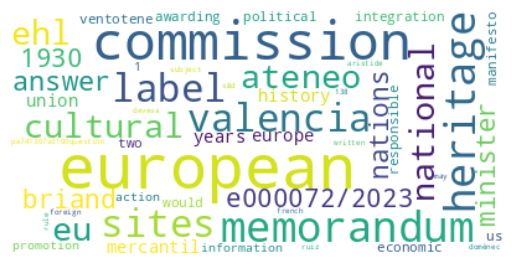

In [33]:
generate_word_clouds(dict(data.keywords.values[20]))


## Mehrere Wörter - Bigrams und Trigrams

In [74]:
from nltk.collocations import *
bigrams = nltk.collocations.BigramAssocMeasures()

In [78]:
bigrams = list(nltk.bigrams(data.clean_text.values[10].split()))

fdist = FreqDist(bigrams)
fdist.most_common(10)

[(('oj', 'l'), 4),
 (('forest', 'management'), 3),
 (('carbon', 'sinks'), 3),
 (('commission', 'warnings'), 2),
 (('swedish', 'forest'), 2),
 (('sweden', 'also'), 2),
 (('forestry', 'industry'), 2),
 (('eu', 'market'), 2),
 (('energy', 'renewable'), 2),
 (('sinks', 'stocks'), 2)]

In [101]:
data.keywords

Unnamed: 0
0       [(eu, 12), (morocco, 9), (commission, 6), (fin...
1       [(medicines, 14), (eu, 7), (shortages, 7), (co...
2       [(rights, 8), (peru, 6), (human, 6), (governme...
3       [(medicines, 11), (shortages, 9), (commission,...
4       [(regulation, 11), (interventions, 6), (electr...
                              ...                        
1498    [(arms, 5), (russia, 5), (egypt, 5), (union, 4...
1499    [(commission, 4), (information, 3), (question,...
1500    [(myanmar, 10), (project, 7), (commission, 5),...
1501    [(commission, 7), (id, 5), (european, 4), (mus...
1502    [(deaths, 4), (commission, 3), (workrelated, 3...
Name: keywords, Length: 1503, dtype: object

# Search for documents by keyword

In [118]:
def get_related_documents(data, keyword, cols):
    keyword = keyword.lower()
    # Create an empty list to store the relevancy scores
    relevancy_scores = []

    # Iterate over each row in the dataframe
    for index, row in data.iterrows():
        document_keywords = dict(row['keywords'])

        # Check if the keyword exists in the document's keywords
        if keyword in document_keywords:
            # Get the frequency of the keyword in the document
            frequency = document_keywords[keyword]
            
            # Append the relevancy score (frequency) and document index to the list
            relevancy_scores.append((frequency, index))
    
    # Sort the relevancy scores in descending order
    relevancy_scores.sort(reverse=True)
    
    # Get the document indices from the sorted relevancy scores
    document_indices = [score[1] for score in relevancy_scores]
    
    # Return the list of documents related to the keyword, sorted by relevancy
    return data[cols].loc[document_indices]

In [123]:
cols = ['document_title','keywords', 'text']
get_related_documents(data, 'education', cols)

,document_title,keywords,text
Unnamed: 0,,,
361,Discrimination regarding recognition of gradua...,"[(education, 12), (studies, 9), (recognition, ...",PE743.383v01-00Question for written answer E-0...
511,Providing environmental education and combatin...,"[(climate, 11), (commission, 7), (education, 7...",PE745.073v02-00Question for written answer E-0...
312,EU legislation covering academic and professio...,"[(qualifications, 17), (recognition, 17), (eur...",PE743.384v01-00Question for written answer E-0...
480,Standardising the dental hygienist profession ...,"[(dental, 40), (hygienist, 23), (training, 23)...",PE744.242v01-00Question for written answer E-0...
626,Aid to Afghanistan and the situation of Afghan...,"[(women, 20), (eu, 10), (humanitarian, 9), (co...",PE745.733v01-00Question for written answer E-0...
532,EU measures in view of the violation of human ...,"[(tibetan, 22), (rights, 19), (human, 11), (eu...",PE745.083v01-00Question for written answer E-0...
184,Standardisation of laboratory technician degre...,"[(member, 10), (qualifications, 9), (technicia...",PE741.555v01-00Question for written answer E-0...
1308,Request to revise the Erasmus+ programme to ma...,"[(students, 11), (grant, 9), (erasmus+, 8), (c...",PE742.766v01-00Priority question for written a...
1241,Commission support for pre-schools and schools...,"[(schools, 16), (special, 10), (support, 6), (...",PE748.882v01-00Question for written answer E-0...


# Further Resources

## TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical representation used in Natural Language Processing that measures the importance of a word in a document by considering both its frequency within the document (TF) and its rarity across the entire collection of documents (IDF). It helps identify words that are both frequent within a specific document and unique to that document, thus capturing their relative significance in distinguishing documents from each other.